# I want to actually make an LSTM
I will use the data in entero_unique_arg.csv, break each entry up into a list of 14 long characters that move over a space each time. The 15th character will be the one that the neural net is trying to predict. 


For each line of the input data I want to give it a 12 position long random "seed" along with a "start" character which I have decided is ":".

In [63]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import matplotlib.patches as patches


print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if tf.test.is_gpu_available() else "NOT AVAILABLE")

Tensor Flow Version: 2.4.0
Keras Version: 2.4.0

Python 3.8.12 | packaged by conda-forge | (default, Oct 12 2021, 21:59:51) 
[GCC 9.4.0]
Pandas 1.3.3
Scikit-Learn 1.0
GPU is NOT AVAILABLE


2022-01-26 19:22:02.535835: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [189]:
import pandas as pd
import numpy as np
import random

np.random.seed(42)
pd.set_option('display.max_rows', 1000)
pd.set_option( 'display.max_colwidth', None )

df = pd.read_csv('data/entero_unique_arg.csv', skiprows=3, names=['sequences'])
FRAG_SIZE = 14 # Cannot be smaller than 10
LONGEST_TRNA = max(df['sequences'].map(len))
OUTPUT_LETTERS = ['A', 'C', 'G', 'T', 'P']
INPUT_LETTERS = ['C', 'A', 'G', 'T', 'P', "R",
                'B', 'D', 'E', 'F', 'H', 'I',
                'J', 'K', 'L', 'M', 'O', 'Q', 'S', 'T', 
                 'U', 'V', 'W', 'X', 'Y', 'Z']
INPUT_LETTERS = set(INPUT_LETTERS)
RAND_LETTERS = ['B', 'D', 'E', 'F', 'H', 'I',
                'J', 'K', 'L', 'M', 'O', 'Q', 'S', 'T', 
                 'U', 'V', 'W', 'X', 'Y', 'Z']
display(df.head())

,sequences
0,GCATCCGTAGTTCAGTTGGAtAGAGCACTCGGCTACGAACCGAGAGGtCGGAGGTTCAAATCCTTCCGGATGCA
1,GCGCTTGTAGCTCAGTTGGAtAGAGCGCTACCCTCCGAAGGTAGAGGcCTCAGGTTCGAATCCTGTCAAGCGCA
2,GCGCTCTTAGCTCAGATGGAtAGAGCAACGGCCTTCTAAGCCGTAGGtCATAGGTTCGAATCCTATAGAGCGCA
3,GCGCCCTTAGCTCAGTTGGAtAGAGCAACGACCTTCTAAGTCGTGGGcCGCAGGTTCGAATCCTGCAGGGCGCG
4,GTCCTCTTAGTTAAATGGAtATAACGAGCCCCTCCTAAGGGCTAAtTGCAGGTTCGATTCCTGCAGGGGACA


In [190]:
uniqueChars = {'A': 0, 'C': 1, 'G':2, 'T':3, 'P':4}

def add_prefix(sequence):
    '''
    This now appends 6 random letters (20^6 = 64000000 combinations)
    and the FRAG_SIZE - 6 'R' to make a semi-consistent start prefix.
    Sequence is a list as given by a .map function. But I guess a normal
    string would work as well.
    '''
    prefix = [RAND_LETTERS[random.randint(0,19)] for i in range(1,7)]
    prefix2 = list((FRAG_SIZE-len(prefix)) * 'R')
    prefix.extend(prefix2)
    prefix.extend(sequence)
    return prefix

def add_suffix(sequence):
    sequence.append('P')
    return sequence

def split_sequence(sequence):
    return [str(x) for x in sequence]

def make_X(sequence):
    steps = len(sequence)-FRAG_SIZE
    train = []
    for step in range(steps):
        train.append( sequence[step:FRAG_SIZE+step+1] )
    return train
    
def make_y(sequence):
    steps = len(sequence)-FRAG_SIZE+1
    predict = []
    for step in range(steps):
        predict.append( sequence[FRAG_SIZE+step-1] )
    return predict

def make_dummy(item):
    try:
        return uniqueChars[item]
    except KeyError:
        return item
            
def make_one_hot(sequence, categories=['a', 'b', 'c']):
    '''
    Given a list of values, and a list of potential categories
    return a 2D, onehot encoded list of values.
    '''
    shape = ( len(sequence), len(categories) )
    one_hot = np.zeros(shape , dtype=int )
    for n,item in enumerate(sequence):
        index = categories.index(item)
        one_hot[n,index] = 1
    return one_hot

def make_series_cat(series, categories):
    '''
    Given a column of a dataframe, make it a categoricalDtype
    for make_dummies
    '''
    return series.astype(pd.CategoricalDtype(categories=categories))

def make_sentence_cat(sentence, categories=list(uniqueChars.keys())):
    # Given a list "sentence" return it one-hot encoded
    sentence = pd.DataFrame(sentence).T
    sentence = sentence.apply(make_series_cat, axis='columns', categories=categories )
    return pd.get_dummies(sentence)

def make_dummies(sequence, categories=None):
    # Given a list "sequence" return it one-hot encoded
    # This automatically finds all the unique values in
    # the input and makes them the categories. Requires
    # numpy and pandas as imports
    if not categories:
        categories = set(np.array(sequence).flatten())
    sequence = pd.DataFrame(sequence, 
                            dtype=pd.CategoricalDtype(categories=categories))
    sequence = pd.get_dummies(sequence)
    return np.array(sequence)

In [21]:
example = [0.3745401188473625,
  0.9507143064099162,
  0.7319939418114051,
  0.5986584841970366,
  0.15601864044243652,
  0.15599452033620265,
  0.05808361216819946,
  0.8661761457749352,
  0.6011150117432088,
  0.7080725777960455,
  0.020584494295802447,
  0.9699098521619943,
  0.8324426408004217,
  ':',
  'G',
  'C',
  'A',
  'T',
  'C',
  'C',
  'G',
  'T',
  'A',
  'G',
  'T',
  'T',
  'C',
  'A',
  'G',
  'T',
  'T',
  'G',
  'G',
  'A',
  't',
  'A',
  'G',
  'A',
  'G',
  'C',
  'A',
  'C',
  'T',
  'C',
  'G',
  'G',
  'C',
  'T',
  'A',
  'C',
  'G',
  'A',
  'A',
  'C',
  'C',
  'G',
  'A',
  'G',
  'A',
  'G',
  'G',
  't',
  'C',
  'G',
  'G',
  'A',
  'G',
  'G',
  'T',
  'T',
  'C',
  'A',
  'A',
  'A',
  'T',
  'C',
  'C',
  'T',
  'T',
  'C',
  'C',
  'G',
  'G',
  'A',
  'T',
  'G',
  'C',
  'A',
  ';']

In [191]:
# I changed this to incorporate the keras pad_sequences function
df['upper_sequences'] = df['sequences'].map( str.upper )
df['split_sequences'] = df['upper_sequences'].map( split_sequence )
df['padded_sequences'] = pad_sequences(df.split_sequences, dtype=object, maxlen=LONGEST_TRNA, padding='post', value='P').tolist()
df['complete_sequences'] = df['padded_sequences'].map( add_prefix )

df.head()

,sequences,upper_sequences,split_sequences,padded_sequences,complete_sequences
0,GCATCCGTAGTTCAGTTGGAtAGAGCACTCGGCTACGAACCGAGAGGtCGGAGGTTCAAATCCTTCCGGATGCA,GCATCCGTAGTTCAGTTGGATAGAGCACTCGGCTACGAACCGAGAGGTCGGAGGTTCAAATCCTTCCGGATGCA,"[G, C, A, T, C, C, G, T, A, G, T, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, A, C, T, C, G, G, C, T, A, C, G, A, A, C, C, G, A, G, A, G, G, T, C, G, G, A, G, G, T, T, C, A, A, A, T, C, C, T, T, C, C, G, G, A, T, G, C, A]","[G, C, A, T, C, C, G, T, A, G, T, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, A, C, T, C, G, G, C, T, A, C, G, A, A, C, C, G, A, G, A, G, G, T, C, G, G, A, G, G, T, T, C, A, A, A, T, C, C, T, T, C, C, G, G, A, T, G, C, A, P]","[W, W, E, Q, W, E, R, R, R, R, R, R, R, R, G, C, A, T, C, C, G, T, A, G, T, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, A, C, T, C, G, G, C, T, A, C, G, A, A, C, C, G, A, G, A, G, G, T, C, G, G, A, G, G, T, T, C, A, A, A, T, C, C, T, T, C, C, G, G, A, T, G, C, A, P]"
1,GCGCTTGTAGCTCAGTTGGAtAGAGCGCTACCCTCCGAAGGTAGAGGcCTCAGGTTCGAATCCTGTCAAGCGCA,GCGCTTGTAGCTCAGTTGGATAGAGCGCTACCCTCCGAAGGTAGAGGCCTCAGGTTCGAATCCTGTCAAGCGCA,"[G, C, G, C, T, T, G, T, A, G, C, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, G, C, T, A, C, C, C, T, C, C, G, A, A, G, G, T, A, G, A, G, G, C, C, T, C, A, G, G, T, T, C, G, A, A, T, C, C, T, G, T, C, A, A, G, C, G, C, A]","[G, C, G, C, T, T, G, T, A, G, C, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, G, C, T, A, C, C, C, T, C, C, G, A, A, G, G, T, A, G, A, G, G, C, C, T, C, A, G, G, T, T, C, G, A, A, T, C, C, T, G, T, C, A, A, G, C, G, C, A, P]","[W, F, Z, X, D, Z, R, R, R, R, R, R, R, R, G, C, G, C, T, T, G, T, A, G, C, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, G, C, T, A, C, C, C, T, C, C, G, A, A, G, G, T, A, G, A, G, G, C, C, T, C, A, G, G, T, T, C, G, A, A, T, C, C, T, G, T, C, A, A, G, C, G, C, A, P]"
2,GCGCTCTTAGCTCAGATGGAtAGAGCAACGGCCTTCTAAGCCGTAGGtCATAGGTTCGAATCCTATAGAGCGCA,GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGAGCGCA,"[G, C, G, C, T, C, T, T, A, G, C, T, C, A, G, A, T, G, G, A, T, A, G, A, G, C, A, A, C, G, G, C, C, T, T, C, T, A, A, G, C, C, G, T, A, G, G, T, C, A, T, A, G, G, T, T, C, G, A, A, T, C, C, T, A, T, A, G, A, G, C, G, C, A]","[G, C, G, C, T, C, T, T, A, G, C, T, C, A, G, A, T, G, G, A, T, A, G, A, G, C, A, A, C, G, G, C, C, T, T, C, T, A, A, G, C, C, G, T, A, G, G, T, C, A, T, A, G, G, T, T, C, G, A, A, T, C, C, T, A, T, A, G, A, G, C, G, C, A, P]","[Q, X, U, H, V, D, R, R, R, R, R, R, R, R, G, C, G, C, T, C, T, T, A, G, C, T, C, A, G, A, T, G, G, A, T, A, G, A, G, C, A, A, C, G, G, C, C, T, T, C, T, A, A, G, C, C, G, T, A, G, G, T, C, A, T, A, G, G, T, T, C, G, A, A, T, C, C, T, A, T, A, G, A, G, C, G, C, A, P]"
3,GCGCCCTTAGCTCAGTTGGAtAGAGCAACGACCTTCTAAGTCGTGGGcCGCAGGTTCGAATCCTGCAGGGCGCG,GCGCCCTTAGCTCAGTTGGATAGAGCAACGACCTTCTAAGTCGTGGGCCGCAGGTTCGAATCCTGCAGGGCGCG,"[G, C, G, C, C, C, T, T, A, G, C, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, A, A, C, G, A, C, C, T, T, C, T, A, A, G, T, C, G, T, G, G, G, C, C, G, C, A, G, G, T, T, C, G, A, A, T, C, C, T, G, C, A, G, G, G, C, G, C, G]","[G, C, G, C, C, C, T, T, A, G, C, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, A, A, C, G, A, C, C, T, T, C, T, A, A, G, T, C, G, T, G, G, G, C, C, G, C, A, G, G, T, T, C, G, A, A, T, C, C, T, G, C, A, G, G, G, C, G, C, G, P]","[F, I, X, K, E, L, R, R, R, R, R, R, R, R, G, C, G, C, C, C, T, T, A, G, C, T, C, A, G, T, T, G, G, A, T, A, G, A, G, C, A, A, C, G, A, C, C, T, T, C, T, A, A, G, T, C, G, T, G, G, G, C, C, G, C, A, G, G, T, T, C, G, A, A, T, C, C, T, G, C, A, G, G, G, C, G, C, G, P]"
4,GTCCTCTTAGTTAAATGGAtATAACGAGCCCCTCCTAAGGGCTAAtTGCAGGTTCGATTCCTGCAGGGGACA,GTCCTCTTAGTTAAATGGATATAACGAGCCCCTCCTAAGGGCTAATTGCAGGTTCGATTCCTGCAGGGGACA,"[G, T, C, C, T, C, T, T, A, G, T, T, A, A, A, T, G, G, A, T, A, T, A, A, C, G, A, G, C, C, C, C, T, C, C, T, A, A, G, G, G, C, T, A, A, T, T, G, C, A, G, G, T, T, C, G, A, T, T, C, C, T, G, C, A, G, G, G, G, A, C, A]","[G, T, C, C, T, C, T, T, A, G, T, T, A, A, A, T, G, G

In [129]:
X = []
y = []
for sequence in df['complete_sequences']:
    X.extend(make_X(sequence))

In [130]:
X[0]

['I', 'M', 'D', 'X', 'J', 'E', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'G']

In [131]:
columns = [f'X_{x}' for x in range(FRAG_SIZE)]
columns.append('y')

dataset = pd.DataFrame(X, columns=columns)
display(dataset.head())
dataset.shape

,X_0,X_1,X_2,X_3,X_4,X_5,X_6,X_7,X_8,X_9,X_10,X_11,X_12,X_13,y
0,I,M,D,X,J,E,R,R,R,R,R,R,R,R,G
1,M,D,X,J,E,R,R,R,R,R,R,R,R,G,C
2,D,X,J,E,R,R,R,R,R,R,R,R,G,C,A
3,X,J,E,R,R,R,R,R,R,R,R,G,C,A,T
4,J,E,R,R,R,R,R,R,R,R,G,C,A,T,C


(16650, 15)

In [132]:
# Just looking how many tRNAs start with each letter
dataset[ dataset['X_13']=='R' ].groupby('y')['y'].count()

y
A      3
C     11
G    202
T      6
Name: y, dtype: int64

In [164]:
# Lets get the basic stats that Jeff was getting
chars = df['complete_sequences'].map(lambda calc: len(calc)).sum()
uniqueNums = {value:key for key, value in uniqueChars.items()}
display(uniqueNums)
uniqueChars

{0: 'A', 1: 'C', 2: 'G', 3: 'T', 4: 'P'}

{'A': 0, 'C': 1, 'G': 2, 'T': 3, 'P': 4}

In [134]:
# Lets one-hot using pandas .make_dummy function rather than make up our own shit :\
# https://stackoverflow.com/questions/37425961/dummy-variables-when-not-all-categories-are-present
# This post makes it seem rather possible, and wow it worked great!
mask = dataset.columns.str.contains('X')
datasetX = dataset.loc[:,mask].apply( make_series_cat, axis = 'columns', categories=INPUT_LETTERS )
datasetY = dataset.loc[:,~mask].apply( make_series_cat, axis = 'columns', categories=OUTPUT_LETTERS )
datasetX = pd.get_dummies(datasetX)
datasetY = pd.get_dummies(datasetY)

In [135]:
display(datasetX.head())
display(datasetY.head())

,X_0_B,X_0_C,X_0_H,X_0_G,X_0_M,X_0_Z,X_0_D,X_0_J,X_0_V,X_0_R,...,X_13_A,X_13_X,X_13_L,X_13_Y,X_13_F,X_13_K,X_13_Q,X_13_E,X_13_T,X_13_O
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


,y_A,y_C,y_G,y_T,y_P
0,0,0,1,0,0
1,0,1,0,0,0
2,1,0,0,0,0
3,0,0,0,1,0
4,0,1,0,0,0


In [136]:
dataset = pd.concat([datasetX, datasetY], axis=1)

In [137]:
dataset.to_csv('data/processed_LSTM_dataset_one_hot.csv', index=False)

In [138]:
dataset.head()

,X_0_B,X_0_C,X_0_H,X_0_G,X_0_M,X_0_Z,X_0_D,X_0_J,X_0_V,X_0_R,...,X_13_K,X_13_Q,X_13_E,X_13_T,X_13_O,y_A,y_C,y_G,y_T,y_P
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0


# I HAVE MADE MY DATASET
Now lets train the LSTM finally!!!

In [139]:
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.utils import get_file
#from tensorflow.python.ops.math_ops import reduce_prod
import numpy as np
import pandas as pd
import random
import sys
import io
import requests
import re

In [140]:
df = pd.read_csv('data/processed_LSTM_dataset_one_hot.csv')
display(df.head())
df.shape

,X_0_B,X_0_C,X_0_H,X_0_G,X_0_M,X_0_Z,X_0_D,X_0_J,X_0_V,X_0_R,...,X_13_K,X_13_Q,X_13_E,X_13_T,X_13_O,y_A,y_C,y_G,y_T,y_P
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0


(16650, 355)

In [141]:
#df = df.astype({'X_13':'float64'})
df.dtypes

X_0_B     int64
X_0_C     int64
X_0_H     int64
X_0_G     int64
X_0_M     int64
X_0_Z     int64
X_0_D     int64
X_0_J     int64
X_0_V     int64
X_0_R     int64
X_0_U     int64
X_0_I     int64
X_0_P     int64
X_0_W     int64
X_0_S     int64
X_0_A     int64
X_0_X     int64
X_0_L     int64
X_0_Y     int64
X_0_F     int64
X_0_K     int64
X_0_Q     int64
X_0_E     int64
X_0_T     int64
X_0_O     int64
X_1_B     int64
X_1_C     int64
X_1_H     int64
X_1_G     int64
X_1_M     int64
X_1_Z     int64
X_1_D     int64
X_1_J     int64
X_1_V     int64
X_1_R     int64
X_1_U     int64
X_1_I     int64
X_1_P     int64
X_1_W     int64
X_1_S     int64
X_1_A     int64
X_1_X     int64
X_1_L     int64
X_1_Y     int64
X_1_F     int64
X_1_K     int64
X_1_Q     int64
X_1_E     int64
X_1_T     int64
X_1_O     int64
X_2_B     int64
X_2_C     int64
X_2_H     int64
X_2_G     int64
X_2_M     int64
X_2_Z     int64
X_2_D     int64
X_2_J     int64
X_2_V     int64
X_2_R     int64
X_2_U     int64
X_2_I     int64
X_2_P   

In [94]:
df.head()

,X_0_B,X_0_C,X_0_H,X_0_G,X_0_M,X_0_Z,X_0_D,X_0_J,X_0_V,X_0_R,...,X_13_K,X_13_Q,X_13_E,X_13_T,X_13_O,y_C,y_A,y_G,y_T,y_P
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0


In [70]:
#Lets vectorize this (or not)
#We can also just leave it as our numbers

In [142]:
featureLength = df.shape[0]
timeStepLength = FRAG_SIZE
concurrentFeatureLength = len(INPUT_LETTERS)
print('Rolls of film: {}\nInteresting sections per film: {}\nConcurrent films: {}'.format(featureLength, timeStepLength, concurrentFeatureLength))
#dataList = list(df.values.tolist())

Rolls of film: 16650
Interesting sections per film: 14
Concurrent films: 25


In [143]:
mask = df.columns.str.contains('X')
mask_y = df.columns.str.contains('y')
X = np.array( list(df.loc[:,mask].values.tolist()), dtype='int64' )
y = np.array( list(df.loc[:,mask_y].values.tolist()) )

In [147]:
display(uniqueChars.keys())
y[0:5,]

dict_keys(['A', 'C', 'G', 'T', 'P'])

array([[0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0]])

The above stuff shows the spread of each of the different characters in the neural nets vocabulary. Strange that it never says C considering that is its second highest vocab
===

The way I understand this next part is that
* samples: well how many samples there are
* timesteps: Having vectorized the data, how many points before the one we trying to predict
* features: This one is a bit tough, but I think it has to do with dummy variables

In [148]:
#                 samples,   timesteps,  features   ::: https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
X = np.reshape(X, (X.shape[0], FRAG_SIZE, len(INPUT_LETTERS)))

In [150]:
print(uniqueChars)
y[0]

{'A': 1, 'C': 2, 'G': 3, 'T': 4, 'P': 5}


array([0, 0, 1, 0, 0])

# Here is we actually frame the probelm
I followed Jeff Heaton, and he had a categorical problem. But...I think if I change how my y is, I can frame this as a regression! So I would have one output neuron and I would use a different loss function, like maybe RMS or sum of square roots whatever (gonna have to rewatch his vid)

In [221]:
print('Build model')
model = Sequential()
model.add(LSTM(128, input_shape=(FRAG_SIZE, len(INPUT_LETTERS))))
#model.add( Dense(128, activation="relu" ) )
model.add( Dense(len(OUTPUT_LETTERS), activation='softmax') )

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)

Build model


In [222]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128)               78848     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 645       
Total params: 79,493
Trainable params: 79,493
Non-trainable params: 0
_________________________________________________________________


In [223]:
def sample(preds, temperature=1.0):
    '''
    Occaisonally makes an erronous choice that scales
    with temperature. The higher the temp, the sillier
    the neural net becomes.
    '''
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1,preds,1)
    return np.argmax(probas)

uniqueNums

{0: 'A', 1: 'C', 2: 'G', 3: 'T', 4: 'P'}

In [220]:
# Left off at 16:31 of the lstm generate text video...
print(uniqueChars)
print(uniqueNums)
def on_epoch_end(epoch, _):
    # Function invoked at end of each epoch. Prints generated text.
    print("******************************************************")
    print('----- Generating text after Epoch: %d' % epoch)

    #start_index = random.randint(0, len(processed_text) - maxlen - 1)
    for temperature in [0.01, 0.4]:
        print('----- temperature:', temperature)

        generated = ''
        
        sentence = add_prefix("")
        print(f'Sentence: {sentence}')
        
        print(f'----- Generating with seed: "{sentence}"')
        #sys.stdout.write(sentence)
        for i in range(80):
            x_pred = make_dummies(sentence, categories=INPUT_LETTERS).reshape(1, timeStepLength, len(INPUT_LETTERS))
            preds = model.predict(x_pred, verbose=0)[0]
            
            next_index = sample(preds, temperature)
            next_char = uniqueNums[next_index]

            generated += next_char
            sentence.append(next_char)
            sentence = sentence[1:]
            
            #print(sentence)
            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

{'A': 0, 'C': 1, 'G': 2, 'T': 3, 'P': 4}
{0: 'A', 1: 'C', 2: 'G', 3: 'T', 4: 'P'}


In [ ]:
# Ignore useless W0819 warnings generated by TensorFlow 2.0.  Hopefully can remove this ignore in the future.
# See https://github.com/tensorflow/tensorflow/issues/31308
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

# Fit the model
print_callback = LambdaCallback(on_epoch_end=on_epoch_end)

epochs=500
history = model.fit(X, y,
          batch_size=50, # 50 was pretty good
          epochs=epochs)#,     # 20 was pretty good
          #callbacks=[print_callback])

In [107]:
# I am able to create tRNAs, and even pseudogenes that are bacterial looking even
# when I have a loss of 0.3. I ran some of my lower-temp results through blast
# and was getting hits to Arg-tRNAs outside of my enterobacterales training set
# but that might have been just because that tRNA is well conserved. 

# tRNASCAN-se was also saying I'm producing Arg-tRNAs, so that is nice. The higher
# temp (more random) sequences were producing pseudogenes of Arg-tRNAs.

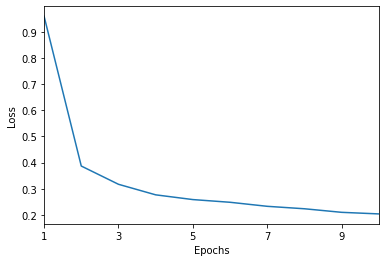

In [225]:
plt.xlim(1,epochs)
plt.xticks(np.arange(1,epochs,2))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(range(1,epochs+1),history.history['loss'])

In [236]:
model.save(f'./LSTM_models/Arg_tRNA_generator_{epochs}-epochs_{history.history["loss"][-1]}-loss')

In [234]:
history.history['loss'][-1]

0.20336474478244781

In [226]:
for i in range(200):
    sentence = add_prefix("")
    kernel = sentence
    sentence = make_dummies(sentence, categories=INPUT_LETTERS).reshape(1, timeStepLength, len(INPUT_LETTERS))
    thing = uniqueNums[ np.argmax( model.predict(sentence, verbose=0) ) ]
    if thing != 'G':
        print('Kernel:', str(kernel))
        print('First output:', thing)
print('done')

Kernel: ['M', 'T', 'Q', 'O', 'T', 'I', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
First output: C
Kernel: ['U', 'T', 'U', 'O', 'I', 'T', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
First output: T
Kernel: ['K', 'Z', 'Q', 'Y', 'Z', 'U', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
First output: A
Kernel: ['I', 'S', 'I', 'T', 'I', 'H', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
First output: T
Kernel: ['K', 'V', 'I', 'J', 'F', 'O', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
First output: C
Kernel: ['B', 'M', 'I', 'E', 'X', 'K', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
First output: C
Kernel: ['K', 'V', 'V', 'Q', 'M', 'M', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
First output: C
Kernel: ['H', 'L', 'K', 'I', 'J', 'Z', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
First output: C
done


In [179]:
model = tf.keras.models.load_model('./LSTM_models/Arg_tRNA_generator_v1')

In [227]:
def make_tRNA(model, characters=80, temperatures=[0.4], verbose = False):
    final_tRNAs = []
    for temperature in temperatures:
        print('----- temperature:', temperature)

        generated = ''
        
        sentence = add_prefix("")
        print(f'----- Kernal: {sentence}')

        for i in range(characters):
            x_pred = make_dummies(sentence, categories=INPUT_LETTERS).reshape(1, timeStepLength, len(INPUT_LETTERS))
            preds = model.predict(x_pred, verbose=0)[0]
            
            next_index = sample(preds, temperature)
            next_char = uniqueNums[next_index]

            generated += next_char
            sentence.append(next_char)
            sentence = sentence[1:]
            
            if verbose:
                print(next_char, end='')
        
        print("\n\n")
        final_tRNAs.append(generated)
    return(generated)
        

In [228]:
fake_tRNAs = []
for i in range(45):
    fake_tRNAs.append(make_tRNA(model, temperatures = [0.01], verbose=True).split('P')[0])

----- temperature: 0.01
----- Kernal: ['K', 'F', 'X', 'J', 'D', 'Z', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGGGCGCAPPPPPP


----- temperature: 0.01
----- Kernal: ['Y', 'U', 'Y', 'H', 'H', 'X', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
GCGCCCTTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCAPPPPPP


----- temperature: 0.01
----- Kernal: ['Q', 'F', 'M', 'W', 'Q', 'D', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCAPPPPPP


----- temperature: 0.01
----- Kernal: ['I', 'M', 'H', 'U', 'V', 'J', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGGGCGCAPPPPPP


----- temperature: 0.01
----- Kernal: ['Z', 'L', 'B', 'E', 'J', 'M', 'R', 'R', 'R', 'R', 'R', 'R', 'R', 'R']
GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGGGCGCAPPPPPP


----- temperature: 0.01
----- Kernal: ['

In [229]:
for n,tRNA in enumerate(fake_tRNAs):
    #print(f'> Fake Arg-{n}\nG{tRNA}')
    print(f'{n}: G{tRNA}')

0: GGCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGGGCGCA
1: GGCGCCCTTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA
2: GGCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA
3: GGCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGGGCGCA
4: GGCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGGGCGCA
5: GGCGCCCTTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA
6: GGCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA
7: GGTTCCCTTAGTTAAATGGATATAACGAGCCCCTCCTAAGGGCTAGTTGCAGGTTCGATTCCTGCAGGGGACA
8: GGCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA
9: GGCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA
10: GGCGCCCTTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA
11: GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA
12: GGCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGT

In [215]:
print([len(x) for x in fake_tRNAs])

[74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74, 74]


In [364]:
'''
I generated 100 sequences, and only 11 were from my original
input data. 89 were unique, not seen by my model. Now I believe
this is due to the temperature thing, so lets try again, but this
time make temp really low so we are just getting raw output.

Doing temp = 0.01 generated a unique tRNA completely unseen by my model,
yet hitting to Arg of the Enterobacterales genus!!! Wowow, and I vetted
my method of checking whether a tRNA is in my dataset, and it does actually
find if there is an exact match (which there isn't). 

A better way would be to perform a needle global alignment between my generated
tRNA and all the input sequences!
'''

"\nI generated 100 sequences, and only 11 were from my original\ninput data. 89 were unique, not seen by my model. Now I believe\nthis is due to the temperature thing, so lets try again, but this\ntime make temp really low so we are just getting raw output.\n\nDoing temp = 0.01 generated a unique tRNA completely unseen by my model,\nyet hitting to Arg of the Enterobacterales genus!!! Wowow, and I vetted\nmy method of checking whether a tRNA is in my dataset, and it does actually\nfind if there is an exact match (which there isn't). \n\nA better way would be to perform a needle global alignment between my generated\ntRNA and all the input sequences!\n"

In [186]:
# Stuff to get me to the point of checking my tRNAs for similarity to training set.
thing = []
for i in range(len(fake_tRNAs)):
    thing.append(fake_tRNAs[i] in list(df['sequences'].map(str.upper)))
print(sum(thing))
thing
list(df['sequences'].map(str.upper)).index( fake_tRNAs[10] )
df.loc[ [13,67] ,]
[x for x in list(df['sequences'].map(str.upper)) if len(x)==71]
df['sequences'].map(str.upper).unique()
fake_tRNAs[11] in list(df.loc[ 13 ,].map(str.upper))
display(list(df.loc[ 13 ,].map(str.upper) ))
fake_tRNAs[10]

KeyError: 'sequences'

# Levenshtein distance
I found this thing here https://en.wikipedia.org/wiki/Levenshtein_distance to calculate
the distnace between my strings. They give a pretty nice formula, and it might be fun
to replicate in code :)

In [192]:
def levenshtein_distance(stringA, stringB):
    '''
    Wow this ran forever basically on just on tRNA, I
    need something better for longer sequences.
    '''
    if len(stringB) == 0:
        return len(stringA)
    elif len(stringA) == 0:
        return len(stringB)
    elif stringA[0] == stringB[0]:
        return levenshtein_distance(stringA[1:], stringB[1:])
    else:
        return 1 + min(levenshtein_distance(stringA[1:], stringB),
                       levenshtein_distance(stringA, stringB[1:]),
                       levenshtein_distance(stringA[1:], stringB[1:]))
    
def eff_levenshtein_distance(stringA, stringB):
    '''
    In the same wiki post, this was there, and it was great.
    I think it really only looks at substitutions high key
    '''
    lev_matrix = np.zeros((len(stringA), len(stringB)))
    subCost = 0
    
    for i in range(len(stringA)):
        lev_matrix[i,0] = i
    for j in range(len(stringB)):
        lev_matrix[0,j] = j
    
    for i in range(1, len(stringA)):
        charA = stringA[i]
        for j in range(1, len(stringB)):
            charB = stringB[j]
            if charA == charB:
                subCost = 0
            else:
                subCost = 1
            lev_matrix[i,j] = min(lev_matrix[i-1,j] + 1,
                                  lev_matrix[i,j-1] + 1,
                                  lev_matrix[i-1,j-1] + subCost)
    return lev_matrix

In [230]:
tracking_similarity = {'fake_tRNA':[], 'closest_tRNA':[], 'lev_score':[]}

for fake_tRNA in fake_tRNAs:
    # Variable initialization
    fake_tRNA = fake_tRNA
    closest_real_tRNA = list(df['sequences'].map(str.upper).unique())[0]
    lowest_score = eff_levenshtein_distance( fake_tRNA, list(df['sequences'].map(str.upper).unique())[0] )[-1,-1]
   
    tracking_similarity['fake_tRNA'].append(fake_tRNA)
    
    for sequence in list(df['sequences'].map(str.upper).unique()):
        if lowest_score > eff_levenshtein_distance( fake_tRNA, sequence )[-1,-1]:
            lowest_score = eff_levenshtein_distance( fake_tRNA, sequence )[-1,-1]
            closest_real_tRNA = sequence
        elif lowest_score == 0:
            break
    tracking_similarity['closest_tRNA'].append(closest_real_tRNA)
    tracking_similarity['lev_score'].append(lowest_score)

In [231]:
tRNAs_invest = pd.DataFrame.from_dict(tracking_similarity, orient='columns'); tRNAs_invest

,fake_tRNA,closest_tRNA,lev_score
0,GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGGGCGCA,GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGAGCGCA,1.0
1,GCGCCCTTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,3.0
2,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,0.0
3,GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGGGCGCA,GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGAGCGCA,1.0
4,GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGGGCGCA,GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGAGCGCA,1.0
5,GCGCCCTTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,3.0
6,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,0.0
7,GTTCCCTTAGTTAAATGGATATAACGAGCCCCTCCTAAGGGCTAGTTGCAGGTTCGATTCCTGCAGGGGACA,GTCCCCTTAGTTAAATGGATATAACGAGCCCCTCCTAAGGGCTAGTTGCAGGTTCGATTCCTGCAGGGGACA,1.0
8,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,0.0
9,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,0.0


In [232]:
for n,tRNA in enumerate(list(tRNAs_invest['fake_tRNA'])):
    #print(f'> Fake Arg-{n}\nG{tRNA}')
    print(n, tRNA)
tRNAs_invest

0 GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGGGCGCA
1 GCGCCCTTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA
2 GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA
3 GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGGGCGCA
4 GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGGGCGCA
5 GCGCCCTTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA
6 GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA
7 GTTCCCTTAGTTAAATGGATATAACGAGCCCCTCCTAAGGGCTAGTTGCAGGTTCGATTCCTGCAGGGGACA
8 GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA
9 GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA
10 GCGCCCTTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA
11 CATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA
12 GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA

,fake_tRNA,closest_tRNA,lev_score
0,GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGGGCGCA,GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGAGCGCA,1.0
1,GCGCCCTTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,3.0
2,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,0.0
3,GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGGGCGCA,GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGAGCGCA,1.0
4,GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGGGCGCA,GCGCTCTTAGCTCAGATGGATAGAGCAACGGCCTTCTAAGCCGTAGGTCATAGGTTCGAATCCTATAGAGCGCA,1.0
5,GCGCCCTTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,3.0
6,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,0.0
7,GTTCCCTTAGTTAAATGGATATAACGAGCCCCTCCTAAGGGCTAGTTGCAGGTTCGATTCCTGCAGGGGACA,GTCCCCTTAGTTAAATGGATATAACGAGCCCCTCCTAAGGGCTAGTTGCAGGTTCGATTCCTGCAGGGGACA,1.0
8,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,0.0
9,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,GCATCCGTAGCTCAGCTGGATAGAGTACTCGGCTACGAACCGAGCGGTCGGAGGTTCGAATCCTCCCGGATGCA,0.0
